In [1]:
# Upgrade Oracle ADS to pick up the latest preview version to maintain compatibility with Oracle Cloud Infrastructure.

!odsc conda install --uri https://objectstorage.us-ashburn-1.oraclecloud.com/p/qnzzHQPGQYghdyH206yDk25MZH1FaMGdNNhKUl74BhRsW4muvFyGViKIqpxgnxI3/n/ociodscdev/b/ads_conda_pack_builds/o/PySpark_3/teamcity_20230512_084146_38972446/f227145b7ee5fc1c73a69ebaa671b81e/PySpark_3.2_and_Feature_Store.tar.gz

Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Feature store handling querying operations</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Managing many datasets, data-sources and transformations for machine learning is complex and costly. Poorly cleaned data, data issues, bugs in transformations, data drift and training serving skew all leads to increased model development time and worse model performance. Here, feature store is well positioned to solve many of the problems since it provides a centralised way to transform and access data for training and serving time and helps defines a standardised pipeline for ingestion of data and querying of data. This notebook demonstrates how to use feature store within a long lasting [Oracle Cloud Infrastructure Data Flow](https://docs.oracle.com/en-us/iaas/data-flow/using/home.htm) cluster.

Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#featurestore_querying'>3. Feature store querying</a>
    - <a href='#data_exploration'>3.1. Exploration of data in feature store</a>
    - <a href='#load_featuregroup'>3.2. Load feature groups</a>
    - <a href='#explore_featuregroup'>3.3. Explore feature groups</a>
    - <a href='#select_subset_featuregroup'>3.4. Select subset of features</a>
    - <a href='#filter_featuregroup'>3.5. Filter feature groups</a>
    - <a href='#join_featuregroup'>3.6. Apply joins on feature group</a>
    - <a href='#create_dataset'>3.7. Create dataset from multiple or one feature group</a>
    - <a href='#sql_query'>3.8 Free form sql query</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg.  All/subset of  features of customer id '2536' can be called as one feature vector.
* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.
* **Entity**: An entity is a group of semantically related features.
* **Datasource**: Features are engineered from raw data stored in various data sources (e.g. object storage, Oracle Database, Oracle MySQL, etc).
* **Feature Group** - A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.
* **Dataset**: Datasets are created from features stored in the feature store service and are used to train models and to perform online model inference.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (fs_pyspark32_p38_cpu_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `fs_pyspark32_p38_cpu_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.

<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='setup_session'></a>
### Session Setup

The notebook makes connections to the Data Catalog metastore and Object Storage. In the next cell, specify the bucket URI to act as the data warehouse. Use the `warehouse_uri` variable with the `oci://<bucket_name>@<namespace_name>/<key>` format. Update the variable `metastore_id` with the OCID of the Data Catalog metastore.

<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [1]:
import ads
ads.set_auth(auth="api_key", client_kwargs={"service_endpoint": "http://{api_gateway_url}/20230101"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [2]:
import os

compartment_id = os.environ.get("NB_SESSION_COMPARTMENT_OCID")
metastore_id = "<metastore_id>"

<a id="featurestore_querying"></a>
# 3. Feature group querying
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and [deeque](https://github.com/awslabs/deequ) libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.

In [4]:
import warnings
warnings.filterwarnings("ignore", message="iteritems is deprecated")
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  warnings.warn(

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

ERROR:logger:Please set env variable SPARK_VERSION
INFO:logger:Using deequ: com.amazon.deequ:deequ:1.2.2-spark-3.0


<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

In [25]:
flights_df = pd.read_csv("/data/flights-data/archives/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]
flights_df.head()

  flights_df = pd.read_csv("~/Downloads/flights.csv")[['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']]



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,2015,1,1,4,AS,98,ANC,SEA
1,2015,1,1,4,AA,2336,LAX,PBI
2,2015,1,1,4,US,840,SFO,CLT
3,2015,1,1,4,AA,258,LAX,MIA
4,2015,1,1,4,AS,135,SEA,ANC


In [6]:
airports_df = pd.read_csv("/data/flights-data/archives/airports.csv")
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [7]:
airlines_df = pd.read_csv("/data/flights-data/archives/airlines.csv")
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [8]:
feature_store_resource = (
    FeatureStore().
    with_description("Data consisting of flights").
    with_compartment_id(compartment_id).
    with_display_name("flights details").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [9]:
feature_store = feature_store_resource.create()
feature_store

kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Data consisting of flights
  displayName: flights details
  id: C48FD6E4D9590E52B5E7130F1350C024
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua
type: featureStore

#### 3.2.2 Entity
An entity is a group of semantically related features.

In [10]:
entity = feature_store.create_entity(
    display_name="Flight details",
    description="description for flight details"
)
entity

kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: description for flight details
  featureStoreId: C48FD6E4D9590E52B5E7130F1350C024
  id: 369DE3D1763AF44708F751CFEF4C448B
  name: Flight details
type: entity

#### 3.2.3 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.

<a id="create_feature_group_flights"></a>
##### Flights Feature Group

Create feature group for flights

In [11]:
feature_group_flights = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["FLIGHT_NUMBER"])
    .with_name("flights_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(flights_df)
)

In [12]:
feature_group_flights.create()

kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 369DE3D1763AF44708F751CFEF4C448B
  featureStoreId: C48FD6E4D9590E52B5E7130F1350C024
  id: 52387B829B77562EFB1C49B5386A92FD
  inputFeatureDetails:
  - featureType: INTEGER
    name: YEAR
    orderNumber: 1
  - featureType: INTEGER
    name: MONTH
    orderNumber: 2
  - featureType: INTEGER
    name: DAY
    orderNumber: 3
  - featureType: INTEGER
    name: DAY_OF_WEEK
    orderNumber: 4
  - featureType: STRING
    name: AIRLINE
    orderNumber: 5
  - featureType: INTEGER
    name: FLIGHT_NUMBER
    orderNumber: 6
  - featureType: STRING
    name: ORIGIN_AIRPORT
    orderNumber: 7
  - featureType: STRING
    name: DESTINATION_AIRPORT
    orderNumber: 8
  name: flights_feature_group
  primaryKeys:
    items:
    - name: FLIGHT_NUMBER
  statisticsConfig:
    isEnabled: true
type: featureGroup

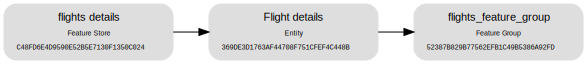

In [13]:
feature_group_flights.show()

In [14]:
os.environ["DEVELOPER_MODE"] = "True"

In [26]:
feature_group_flights.materialise(flights_df)

23/05/15 20:51:43 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `369de3d1763af44708f751cfef4c448b`.`flights_feature_group` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


<a id="create_feature_group_airport"></a>
##### Airport Feature Group

Create feature group for airport

In [16]:
feature_group_airports = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airport_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airports_df)
)

In [17]:
feature_group_airports.create()

kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 369DE3D1763AF44708F751CFEF4C448B
  featureStoreId: C48FD6E4D9590E52B5E7130F1350C024
  id: 8B5787EC2C4502654CCFD342587F8AB9
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - featureType: STRING
    name: AIRPORT
    orderNumber: 2
  - featureType: STRING
    name: CITY
    orderNumber: 3
  - featureType: STRING
    name: STATE
    orderNumber: 4
  - featureType: STRING
    name: COUNTRY
    orderNumber: 5
  - featureType: FLOAT
    name: LATITUDE
    orderNumber: 6
  - featureType: FLOAT
    name: LONGITUDE
    orderNumber: 7
  name: airport_feature_group
  primaryKeys:
    items:
    - name: IATA_CODE
  statisticsConfig:
    isEnabled: true
type: featureGroup

In [18]:
feature_group_airports.materialise(airports_df)

23/05/15 20:46:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
23/05/15 20:46:58 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
23/05/15 20:47:01 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers


23/05/15 20:47:04 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/05/15 20:47:08 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `369de3d1763af44708f751cfef4c448b`.`airport_feature_group` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


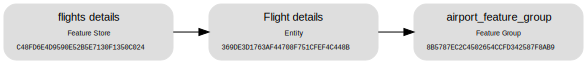

In [19]:
feature_group_airports.show()

<a id="create_feature_group_airlines"></a>
##### Airlines Feature Group

Create feature group for airlines

In [20]:
feature_group_airlines = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys(["IATA_CODE"])
    .with_name("airlines_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(airports_df)
)

In [21]:
feature_group_airlines.create()

kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 369DE3D1763AF44708F751CFEF4C448B
  featureStoreId: C48FD6E4D9590E52B5E7130F1350C024
  id: 783F018A2718FBA8F4A7EBB3B857372B
  inputFeatureDetails:
  - featureType: STRING
    name: IATA_CODE
    orderNumber: 1
  - featureType: STRING
    name: AIRPORT
    orderNumber: 2
  - featureType: STRING
    name: CITY
    orderNumber: 3
  - featureType: STRING
    name: STATE
    orderNumber: 4
  - featureType: STRING
    name: COUNTRY
    orderNumber: 5
  - featureType: FLOAT
    name: LATITUDE
    orderNumber: 6
  - featureType: FLOAT
    name: LONGITUDE
    orderNumber: 7
  name: airlines_feature_group
  primaryKeys:
    items:
    - name: IATA_CODE
  statisticsConfig:
    isEnabled: true
type: featureGroup

<a id="materialise_feature_group"></a>
##### Materialise feature group

You can call the ```materialise() -> FeatureGroupJob``` method of the ```FeatureGroup``` instance to load the data to feature group. To persist the feature group and save feature group  data along the metadata in the feature store, call the ```.materialise()```

In [22]:
feature_group_airlines.materialise(airlines_df)

23/05/15 20:48:15 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `369de3d1763af44708f751cfef4c448b`.`airlines_feature_group` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


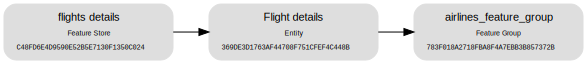

In [23]:
feature_group_airlines.show()

<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups

You can call the ```select()``` method of the ```FeatureGroup``` instance to return ```Query``` interface. ```Query``` interface can be used to join and filter on the feature group.

In [27]:
feature_group_flights.select().show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+
|2015|    1|  1|          4|     UA|         1221|           PDX|                DEN|
|2015|    1|  1|          4|     UA|         1607|           SEA|                DEN|
|2015|    1|  1|          4|     AA|          328|           DEN|                DFW|
|2015|    1|  1|          4|     EV|         5764|           SBN|                ORD|
|2015|    1|  1|          4|     F9|         1279|           PHL|                MCO|
|2015|    1|  1|          4|     NK|          409|           ORD|                FLL|
|2015|    1|  1|          4|     OO|         5460|           RDD|                SFO|
|2015|    1|  1|          4|     OO|         6391|           EUG|                DEN|
|2015|    1|  1|          4|     UA|         1532|    

In [28]:
feature_group_airports.select().show()

+---------+--------------------+---------------+-----+-------+--------+----------+
|IATA_CODE|             AIRPORT|           CITY|STATE|COUNTRY|LATITUDE| LONGITUDE|
+---------+--------------------+---------------+-----+-------+--------+----------+
|      GCK|Garden City Regio...|    Garden City|   KS|    USA|37.92752|-100.72441|
|      GEG|Spokane Internati...|        Spokane|   WA|    USA|47.61986|-117.53384|
|      GFK|Grand Forks Inter...|    Grand Forks|   ND|    USA|47.94926| -97.17611|
|      GGG|East Texas Region...|       Longview|   TX|    USA|32.38486| -94.71171|
|      GJT|Grand Junction Re...| Grand Junction|   CO|    USA|39.12241|-108.52673|
|      GNV|Gainesville Regio...|    Gainesville|   FL|    USA|29.69006| -82.27178|
|      GPT|Gulfport-Biloxi I...|Gulfport-Biloxi|   MS|    USA|30.40728| -89.07009|
|      GRB|Green Bay-Austin ...|      Green Bay|   WI|    USA|44.48507| -88.12959|
|      GRI|Central Nebraska ...|   Grand Island|   NE|    USA|40.96747| -98.30861|
|   

In [34]:
feature_group_airlines.select().show()

+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       EV|Atlantic Southeas...|
|       HA|Hawaiian Airlines...|
|       UA|United Air Lines ...|
|       WN|Southwest Airline...|
|       DL|Delta Air Lines Inc.|
|       MQ|American Eagle Ai...|
|       VX|      Virgin America|
|       OO|Skywest Airlines ...|
|       AS|Alaska Airlines Inc.|
|       NK|    Spirit Air Lines|
+---------+--------------------+
only showing top 10 rows



<a id="feature_group_get_statistics"></a>
##### Get statistics for feature group

You can call the ```get_statistics()``` method of the ```FeatureGroup``` instance to fetch feature group details.

In [29]:
feature_group_airlines.get_statistics().to_pandas()

,IATA_CODE,AIRLINE
completeness,1.0,1.0
approximateNumDistinctValues,13,14
dataType,String,String


In [30]:
feature_group_flights.get_statistics().to_pandas()

,DAY,FLIGHT_NUMBER,AIRLINE,ORIGIN_AIRPORT,DAY_OF_WEEK,MONTH,YEAR,DESTINATION_AIRPORT
completeness,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
approximateNumDistinctValues,1,95,11,42,1,1,1,29
dataType,Integral,Integral,String,String,Integral,Integral,Integral,String
sum,100.0,171151.0,NaN,NaN,400.0,100.0,201500.0,NaN
min,1.0,17.0,NaN,NaN,4.0,1.0,2015.0,NaN
max,1.0,7419.0,NaN,NaN,4.0,1.0,2015.0,NaN
mean,1.0,1711.51,NaN,NaN,4.0,1.0,2015.0,NaN
stddev,0.0,1873.257011,NaN,NaN,0.0,0.0,0.0,NaN


<a id="select_subset_featuregroup"></a>
### 3.4. Select subset of features

You can call the ```select()``` method of the ```FeatureGroup``` instance to return ```Query``` interface. ```Query``` interface can be used to join and filter on the feature group.

In [32]:
feature_group_airlines.select(['IATA_CODE']).show()

+---------+
|IATA_CODE|
+---------+
|       EV|
|       HA|
|       UA|
|       WN|
|       DL|
|       MQ|
|       VX|
|       OO|
|       AS|
|       NK|
+---------+
only showing top 10 rows



<a id="filter_featuregroup"></a>
### 3.5. Filter feature groups

In [33]:
feature_group_airlines.filter(feature_group_airlines.IATA_CODE == "EV").show()

+---------+--------------------+
|IATA_CODE|             AIRLINE|
+---------+--------------------+
|       EV|Atlantic Southeas...|
+---------+--------------------+



<a id="join_featuregroup"></a>
### 3.6. Apply joins on feature group
As in Pandas, if the feature has the same name on both feature groups, then you can use the `on=[]` paramter. If they have different names, then you can use the `left_on=[]` and `right_on=[]` paramters:

In [35]:
from ads.feature_store.common.enums import JoinType

query = (
    feature_group_flights.select()
    .join(feature_group_airlines.select(), left_on=['ORIGIN_AIRPORT'], right_on=['IATA_CODE'], join_type=JoinType.LEFT)
    .join(feature_group_airports.select(), left_on=['AIRLINE'], right_on=['IATA_CODE'], join_type=JoinType.LEFT)
)
query.show(5)

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|AIRPORT|CITY|STATE|COUNTRY|LATITUDE|LONGITUDE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|2015|    1|  1|          4|     UA|         1221|           PDX|                DEN|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     UA|         1607|           SEA|                DEN|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     AA|          328|           DEN|                DFW|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     EV|         5764|           SBN|                ORD|     null|   null|null| null|   null|    null|     null|
|2015|

In [36]:
query.to_string()

'SELECT fg_2.YEAR YEAR, fg_2.MONTH MONTH, fg_2.DAY DAY, fg_2.DAY_OF_WEEK DAY_OF_WEEK, fg_2.AIRLINE AIRLINE, fg_2.FLIGHT_NUMBER FLIGHT_NUMBER, fg_2.ORIGIN_AIRPORT ORIGIN_AIRPORT, fg_2.DESTINATION_AIRPORT DESTINATION_AIRPORT, fg_0.IATA_CODE IATA_CODE, fg_1.AIRPORT AIRPORT, fg_1.CITY CITY, fg_1.STATE STATE, fg_1.COUNTRY COUNTRY, fg_1.LATITUDE LATITUDE, fg_1.LONGITUDE LONGITUDE FROM `369DE3D1763AF44708F751CFEF4C448B`.flights_feature_group fg_2 LEFT JOIN `369DE3D1763AF44708F751CFEF4C448B`.airlines_feature_group fg_0 ON fg_2.ORIGIN_AIRPORT = fg_0.IATA_CODE LEFT JOIN `369DE3D1763AF44708F751CFEF4C448B`.airport_feature_group fg_1 ON fg_2.AIRLINE = fg_1.IATA_CODE'

<a id="create_dataset"></a>
### 3.7 Create dataset
A dataset is a collection of feature snapshots that are joined together to either train a model or perform model inference.

In [39]:
dataset = (
    Dataset()
    .with_description("Combined dataset for flights")
    .with_compartment_id(compartment_id)
    .with_name("flights_dataset")
    .with_entity_id(entity.id)
    .with_feature_store_id(feature_store.id)
    .with_query(query.to_string())
)

<a id="create_dataset"></a>
##### Create Dataset

Call the ```.create()``` method of the Dataset instance to create a dataset.

In [40]:
dataset.create()

kind: Dataset
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Combined dataset for flights
  entityId: 369DE3D1763AF44708F751CFEF4C448B
  featureStoreId: C48FD6E4D9590E52B5E7130F1350C024
  id: A4310D4FF8BC7C9B100D7790E59B7287
  name: flights_dataset
  query: SELECT fg_2.YEAR YEAR, fg_2.MONTH MONTH, fg_2.DAY DAY, fg_2.DAY_OF_WEEK DAY_OF_WEEK,
    fg_2.AIRLINE AIRLINE, fg_2.FLIGHT_NUMBER FLIGHT_NUMBER, fg_2.ORIGIN_AIRPORT ORIGIN_AIRPORT,
    fg_2.DESTINATION_AIRPORT DESTINATION_AIRPORT, fg_0.IATA_CODE IATA_CODE, fg_1.AIRPORT
    AIRPORT, fg_1.CITY CITY, fg_1.STATE STATE, fg_1.COUNTRY COUNTRY, fg_1.LATITUDE
    LATITUDE, fg_1.LONGITUDE LONGITUDE FROM `369DE3D1763AF44708F751CFEF4C448B`.flights_feature_group
    fg_2 LEFT JOIN `369DE3D1763AF44708F751CFEF4C448B`.airlines_feature_group fg_0
    ON fg_2.ORIGIN_AIRPORT = fg_0.IATA_CODE LEFT JOIN `369DE3D1763AF44708F751CFEF4C448B`.airport_feature_group
    fg_1 ON fg_2.AIRLINE

<a id="materialise_dataset"></a>
##### Materialise dataset

You can call the ```materialise() -> DatasetJob``` method of the ```Dataset``` instance to load the data to dataset. To persist the dataset and save dataset data along the metadata in the feature store, call the ```.materialise()```

In [42]:
dataset.materialise()

23/05/15 20:58:01 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `369de3d1763af44708f751cfef4c448b`.`flights_dataset` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.


<a id="visualise_lineage"></a>
##### Visualise lineage

Use the ```.show()``` method on the Dataset instance to visualize the lineage of the dataset.

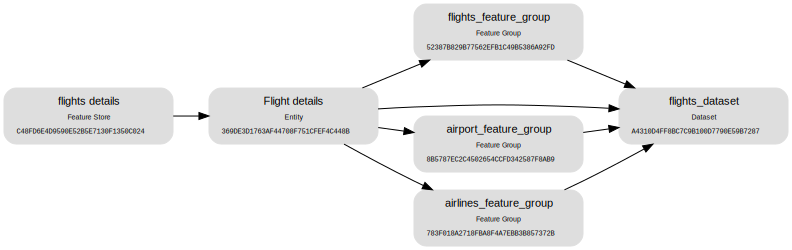

In [44]:
dataset.show()

<a id="profile_dataset"></a>
##### Profilie dataset
You can call the ```.profile()``` method of the ```Dataset``` instance to profile the dataset.

In [46]:
dataset.profile().show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|       lastModified|partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+-------------------+----------------+--------+-----------+----------+----------------+----------------+--------------------+
| delta|6f2bdeb1-6068-440...|369de3d1763af4470...|       null|file:/Users/kshit...|2023-05-15 20:57:...|2023-05-15 20:57:56|              []|       8|      32727|        {}|               1|               2|[appendOnly, inva...|
+------+--------------------+--------------------+-----------+--------------------+-

<a id="preview_dataset"></a>
##### Preview dataset
You can call the ```.preview()``` method of the ```Dataset``` instance to preview the dataset.

In [47]:
dataset.preview().show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|AIRPORT|CITY|STATE|COUNTRY|LATITUDE|LONGITUDE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+-------+----+-----+-------+--------+---------+
|2015|    1|  1|          4|     EV|         4354|           MKE|                IAH|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     US|          425|           PDX|                PHX|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     AA|           89|           IAH|                MIA|     null|   null|null| null|   null|    null|     null|
|2015|    1|  1|          4|     DL|         2099|           BNA|                DTW|     null|   null|null| null|   null|    null|     null|
|2015|

<a id="dataset_get_statistics"></a>
##### Get statistics for dataset

You can call the ```get_statistics()``` method of the ```Dataset``` instance to fetch dataset details.

In [ ]:
dataset.get_statistics().to_pandas()

<a id="sql_query"></a>
### 3.8  Freeform SQL query
Feature store provides a way to query feature store using free flow query. User need to mention `entity id` as the database name and `feature group name` as the table name to query feature store. This functionality can be useful if you need to express more complex queries for your use case

In [80]:
entity_id = entity.id

sql = (f"SELECT flights_feature_group.*, airport_feature_group.IATA_CODE "
       f"FROM `{entity_id}`.flights_feature_group flights_feature_group "
       f"LEFT JOIN `{entity_id}`.airport_feature_group airport_feature_group "
       f"ON flights_feature_group.ORIGIN_AIRPORT=airport_feature_group.IATA_CODE")

In [82]:
feature_store.sql(sql).show()

+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|IATA_CODE|
+----+-----+---+-----------+-------+-------------+--------------+-------------------+---------+
|2015|    1|  1|          4|     UA|         1221|           PDX|                DEN|      PDX|
|2015|    1|  1|          4|     UA|         1607|           SEA|                DEN|      SEA|
|2015|    1|  1|          4|     AA|          328|           DEN|                DFW|      DEN|
|2015|    1|  1|          4|     EV|         5764|           SBN|                ORD|      SBN|
|2015|    1|  1|          4|     F9|         1279|           PHL|                MCO|      PHL|
|2015|    1|  1|          4|     NK|          409|           ORD|                FLL|      ORD|
|2015|    1|  1|          4|     OO|         5460|           RDD|                SFO|      RDD|
|2015|    1|  1|          4|     OO|    

<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)